# CSI 6160 Homework 5
### Samantha Bracellari & Justin Kur

For this assignment, we used the breast cancer wisconsin dataset that can be found in the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer). This dataset has 286 samples and the following features:

1. target: no-recurrence-events, recurrence-events 
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99. 
3. menopause: lt40, ge40, premeno. 
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59. 
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39. 
6. node-caps: yes, no. 
7. deg-malig: 1, 2, 3. 
8. breast: left, right. 
9. breast-quad: left-up, left-low, right-up, right-low, central. 
10. irradiat: yes, no.

We fill any missing values with the mean of that value's respective column, and then finish by performing 5-fold cross validation and splitting the data into train and test sets. 80% of the data will be used for training, while the remaining 20% will be used for testing. We're using stratified k-fold for this assignment to make the ratio of positive and negative classes consistent in each split. If we want that ratio to be 1:1, we would have to under-sample the data. This could potentially hurt the model's accuracy though, since there are already so few examples to begin with.

In [104]:
from sklearn.model_selection import StratifiedKFold
import polars as pl

TARGET = 'column_11'

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # perform 5-fold cross validation with a deterministic seed
    # we use stratified k-fold to help balance each split
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2028)
    split_x, split_y = get_x_y(df)
    splits = list(kf.split(split_x, split_y))

    # indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]

    # fill missing values with column avg
    mean = df_train.get_column('column_7').mean()
    df_train = df_train.with_columns('column_7').fill_null(mean)
    df_test = df_test.with_columns('column_7').fill_null(mean)
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(['column_1', TARGET]), df.get_column(TARGET) # we don't need the ID column
    return X.to_numpy(), y.to_numpy()

df = pl.read_csv('breast-cancer-wisconsin.data', has_header=False, null_values='?')
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

# not exactly 50%, but somewhat close
print('% of positive samples:', 100*(df_test.get_column(TARGET) == 2.0).sum() / len(df_test))

% of positive samples: 65.71428571428571


### SVM using Sci-Kit Learn

We use sklearn's implementation of SVM for this assignment. Using their default values with no split, we can see that the model achieves about a 96% accuracy score.

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.9571428571428572

#### K-Fold & Multiple Accuracy Metrics

We played around with the hyper parameters for the SVM model and ended up using 1.69 for the regularization parameter (C) and `rbf` for the kernel (this is the default kernel value). The kernel coefficient, or the gamma value, was set to `auto`.

In addition to calculating the accuracy score using the model's `score` method (which returns the mean accuracy of the provided test data), we also took a look at the `balanced_accuracy_score`, which is recommended for imbalanced datasets. The breast cancer dataset isn't heavily imbalanced, but we wanted to see if there would be any difference.

In [106]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np

def svm(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', C=1.69)).fit(X_train, y_train)
    pred = model.predict(X_test)
    return [use_split, model.score(X_test, y_test), balanced_accuracy_score(y_test, pred)]

scores = np.array([svm(df, x) for x in range(5)])
df = pl.DataFrame(scores, schema=['split', 'score', 'balanced_score'])
df

split,score,balanced_score
f64,f64,f64
0.0,0.95,0.947011
1.0,0.957143,0.957428
2.0,0.978571,0.973732
3.0,0.971429,0.978022
4.0,0.964029,0.962683


### Results

We can see that both methods perform about the same, with every trial achieving an accuracy score of 95% or above.

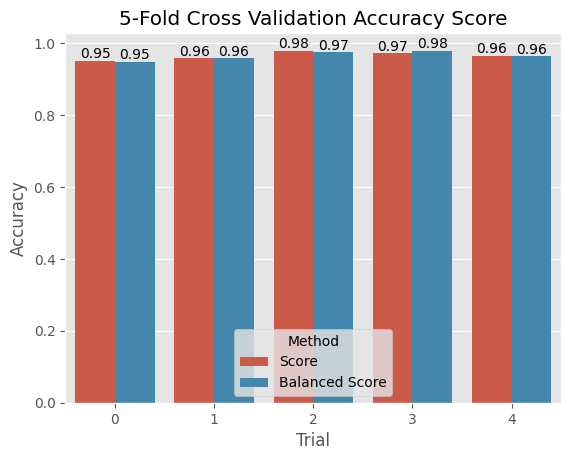

In [107]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()

unbalanced, balanced = scores[:, 1], scores[:, 2]

method = ['Score' for _ in range(5)] + ['Balanced Score' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'Accuracy': np.concatenate([unbalanced,balanced]), 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation Accuracy Score')
seaborn.barplot(data=plot_df, x='Trial', y='Accuracy', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, 'lower center')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')